In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from seisfwi.model import ElasticModel, ElasticModelRBF
from seisfwi.survey import Survey, Source, Receiver, GenericCable, SeismicData
from seisfwi.propagator import ElasticPropagator
from seisfwi.problem import ElasticFWI, WaveformL2Loss

from seisfwi.utils import wavelet, moment_tensor, plot_data, plot_sg, timer, plot_misfit, load_misfit, smooth2d
from seisfwi.utils import layer_model, gmsh_center2d, set_sigma, RBF

## Working path

In [3]:
def plot_2d(x, z, d, centers = None, aspect=5):

    if type(d) is list:
        plt.figure(figsize=(15, 6))

        for i, dd in enumerate(d):
            plt.subplot(1, len(d), i+1)
            plt.imshow(dd, extent=[x[0]/1000, x[-1]/1000, z[-1]/1000, z[0]/1000],aspect=aspect,cmap='jet')
            plt.grid()
            plt.colorbar(orientation='horizontal')
            plt.xlabel("Distance (km)")
            plt.ylabel("Depth (km)")
        
    else:
        plt.figure(figsize=(6, 6))
        plt.imshow(d, extent=[x[0]/1000, x[-1]/1000, z[-1]/1000, z[0]/1000], aspect=aspect,cmap='jet')
        if centers is not None:
            plt.scatter(centers[:,0]/1000, centers[:,1]/1000, marker='.', color = 'r')
        plt.grid()
        plt.colorbar(orientation='horizontal')
        plt.xlabel("Distance (km)")
        plt.ylabel("Depth (km)")
    
    plt.tight_layout()
    plt.show()

def inversion(operator, dobs, niter = 20):

    # observed data
    dobs = torch.tensor(dobs, dtype=torch.float32, device = operator.device)
    
    # optimizer
    optimizer = torch.optim.LBFGS(operator.parameters(), line_search_fn='strong_wolfe')
    
    misfits = []  # List to store the misfit values
    def closure():
        optimizer.zero_grad()
        lam, mu, buoyancy = operator()
        # fit vp
        dsyn = torch.sqrt(mu * buoyancy)
        loss = torch.nn.MSELoss()(dsyn, dobs)
        loss.backward()
        misfits.append(loss.item())  # Record the misfit
    
        return loss
    
    # Run the optimization
    for i in range(niter):
        loss = optimizer.step(closure)
        
        # if i%5 == 0:
        print(f"Iteration: {i + 1}/{niter}, misfit: {loss.item(): .2e}")

    # finial data 
    lam, mu, buoyancy = operator()
    dsyn = torch.sqrt(mu * buoyancy)
    dsyn = dsyn.detach().cpu().numpy()

    return dsyn, np.array(misfits)


In [4]:
path = 'surface-wave'

os.makedirs(path, exist_ok=True)

cmap_range={'vp': (800, 2600), 'vs': (0, 1200), 'rho': (1600, 2250)}

### Parameters for elastic model

In [5]:
ox = 0.0
oz = 0.0
nx = 601  #1501
nz = 41
dx = 10.0
dz = 10.0

nt = 4000
dt = 0.0025
f0 = 5.0
amp = 1e7

x = np.arange(nx) * dx
z = np.arange(nz) * dz

In [6]:
layers = [100, 200, 300, 400,  500,  600]
vels   = [800, 850, 900, 950, 1000, 1100]

vs = layer_model(nx, nz, dx, layers, vels)
vs = smooth2d(vs, 3, 3)
vs0 = vs.copy()
vp0 = vs0 * 1.7
rho0 = np.power(vp0, 0.25) * 310

# vs[5:7,   90:150]  = 600
# vs[3:15,  250:260] = 1000
# vs[25:32, 150:400] = 1100
# vs[6:10,  350:450] = 700

vs[5:7,   90:150]  *= 0.9
vs[3:15,  250:260] *= 1.1
vs[25:32, 150:400] *= 1.2
vs[6:10,  350:450] *= 0.8
# vs[20:,   500:]    = 1200

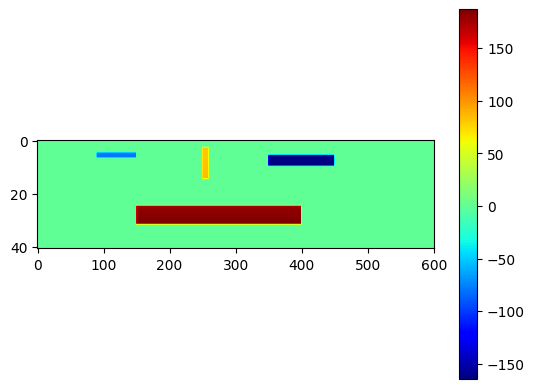

In [7]:
plt.imshow(vs-vs0, aspect=4, cmap='jet',)
plt.colorbar()

In [8]:
vp = vs * 1.7
rho = np.power(vp, 0.25) * 310

model_true = ElasticModel(ox, oz, dx, dz, nx, nz, vp = vp, vs = vs, rho = rho, free_surface=False, nabc=20)
model_true

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1096.20 -  1906.81 m/s   , requires_grad = False, constrain bound: None - None
  Model vs  :   644.82 -  1121.65 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  1783.75 -  2048.51 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =  10.00, dz =  10.00 m
  Model dims: nx =    601, nz =     41
  Model size: 73923
  Free surface: False
  Absorbing layers: 20

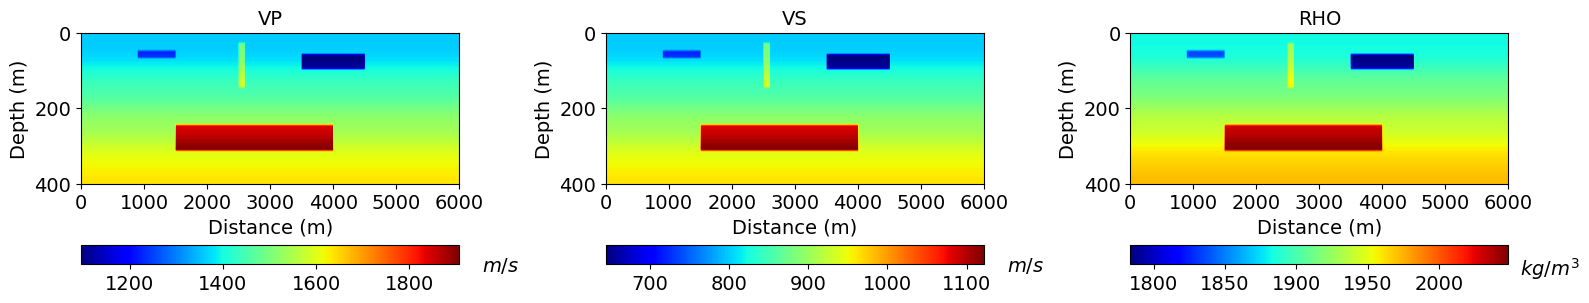

In [9]:
model_true.plot(aspect=6)

In [10]:
# Create a seismic sources
source = Source(nt = nt, dt = dt, f0 = f0)

# Create wavelet
wvlt = wavelet(nt, dt, f0) * amp

# # Set source attributes
for isrc in range(13):
    source.add_source([460 * isrc + 200, dx], wvlt, 'vz')

source

Seismic Source:
  Source wavelet: 4000 samples at 2.50 ms
  Source number : 13
  Source types  : ['vz']
  Source x range: 200.00 - 5720.00 m
  Source z range:  10.00 -  10.00 m

In [11]:
geophone = Receiver(nt = nt, dt = dt)

for isrc in range(290):
    geophone.add_receiver([20 * isrc + 100, dx], 'vz')

In [12]:
survey = Survey(source=source, receiver=geophone, device='cuda', gpu_num=4)

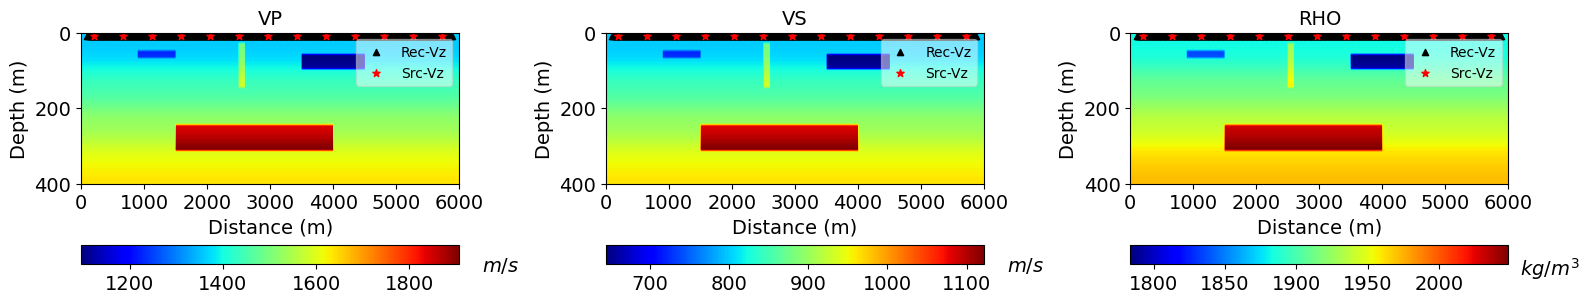

In [13]:
model_true.plot(survey, aspect=6)

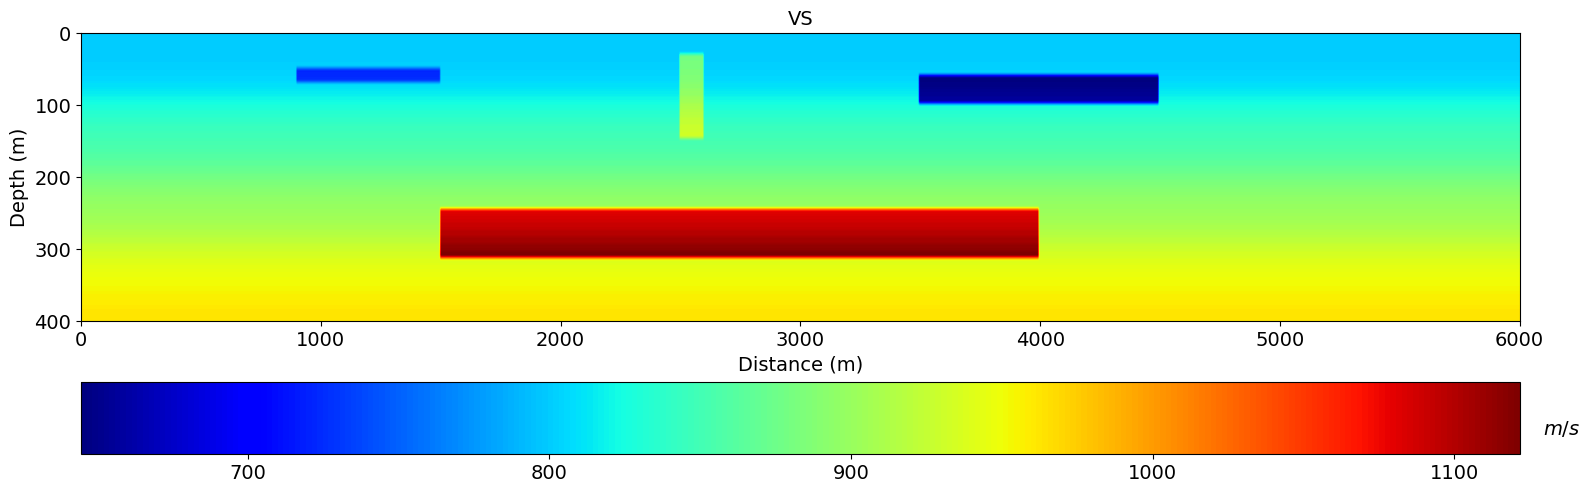

In [14]:
model_true.plot(aspect=3, pars='vs')

In [15]:
F = ElasticPropagator(model_true, survey)

Survey analysis completed: legal survey
free surface: False


In [16]:
dobs = F()

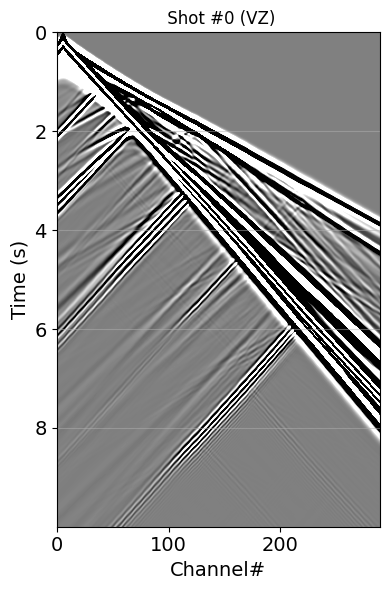

In [17]:
dobs.plot(clip=90, comp={'vz'})

In [18]:
grad_mask = np.ones((nz, nx))
grad_mask[-4:, :] = 0
grad_mask = smooth2d(grad_mask,3,3)

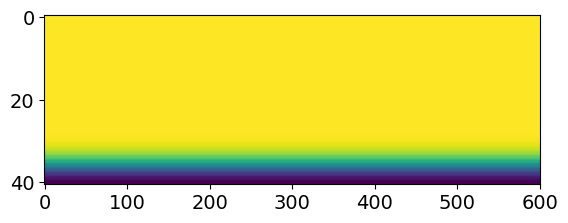

In [19]:
plt.imshow(grad_mask, aspect=5)

In [20]:
model_fwi_fd = ElasticModel(ox, oz, dx, dz, nx, nz,
                     vp = vp0, 
                     vs = vs0, 
                     rho = rho0, 
                     vp_grad = False, 
                     vs_grad = True,
                     rho_grad = False,
                     vp_bound = [500, 3500],
                     vs_bound = [300, 2000],
                     rho_bound = [1400, 2500],
                     free_surface=True, 
                     nabc=20,
                     mask = grad_mask)

model_int = ElasticModel.clone(model_fwi_fd)

model_fwi_fd

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  1360.08 -  1636.98 m/s   , requires_grad = False, constrain bound: 500 - 3500
  Model vs  :   800.05 -   962.93 m/s   , requires_grad = True, constrain bound: 300 - 2000
  Model rho :  1882.58 -  1971.84 kg/m^3, requires_grad = False, constrain bound: 1400 - 2500
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =  10.00, dz =  10.00 m
  Model dims: nx =    601, nz =     41
  Model size: 73923
  Free surface: True
  Absorbing layers: 20

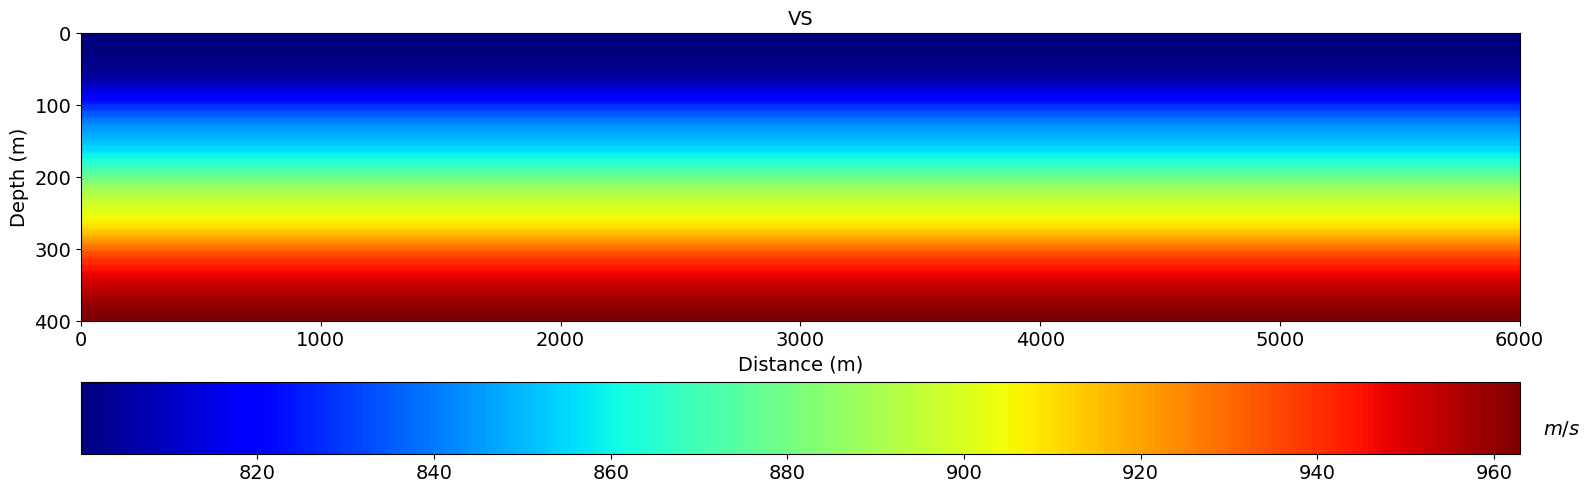

In [21]:
model_fwi_fd.plot(aspect=3, pars='vs')

In [22]:
dsyn = F(model_int)

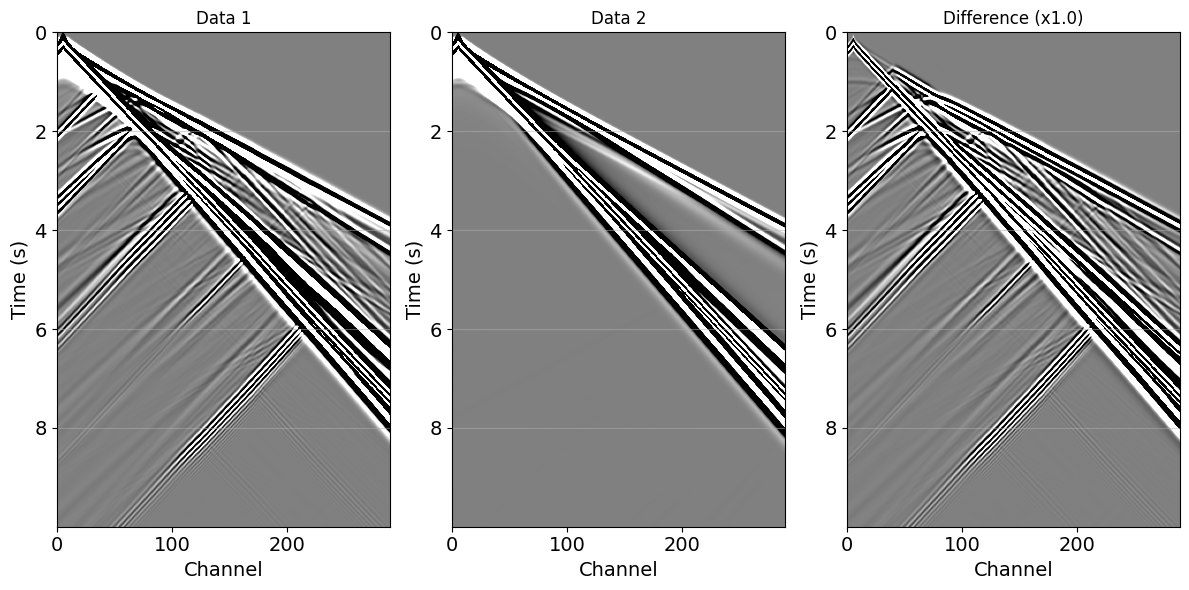

In [23]:
dobs.plot_compare(dsyn, clip=90, comp='vz')

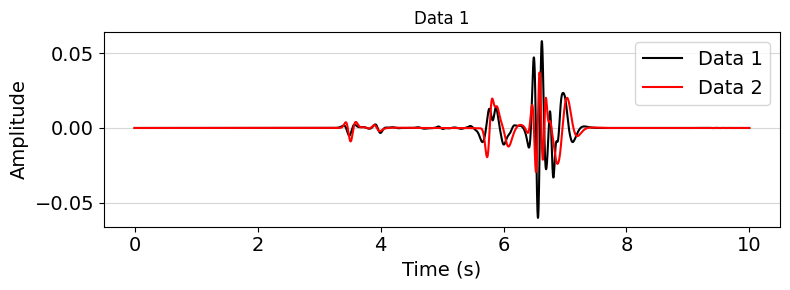

In [24]:
dobs.plot_compare_trace(dsyn, shotid=1, traceid=280, comp='vz')

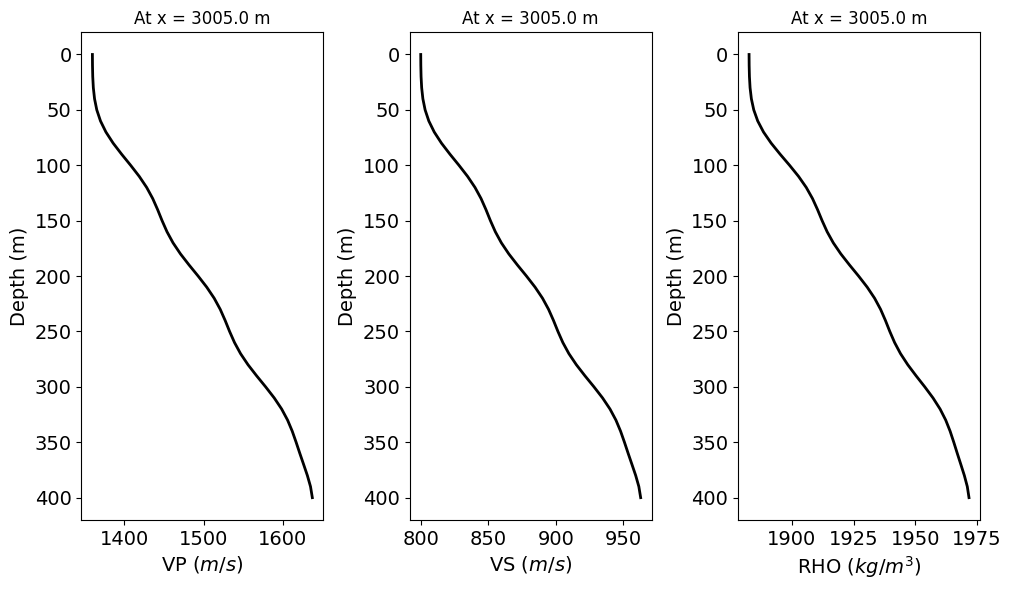

In [25]:
model_fwi_fd.plot_well_log()

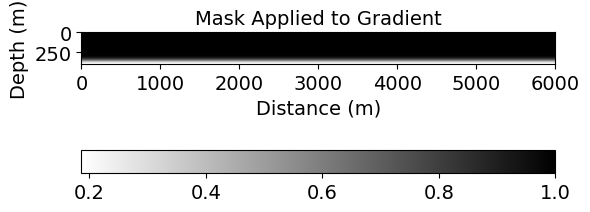

In [26]:
model_fwi_fd.plot_mask()

In [27]:
# Setup optimizer
optimizer = torch.optim.LBFGS(model_fwi_fd.parameters(), 
                  lr = 1.0, 
                  max_iter = 50, 
                  tolerance_change = 1e-4,
                  history_size = 5,
                  line_search_fn = 'strong_wolfe')

# Setup misfit function
misfit = torch.nn.MSELoss()

# Setup components
weight = {'vz': 1.0}

In [28]:
fwi_fd = ElasticFWI(F, model_fwi_fd, optimizer, misfit, dobs, weight)

In [29]:
fwi_fd(nshot_per_gpu_per_batch = 8, max_iter=2, grad_scale = 20.0, grad_interval=4, log_file = 'fwi-surface-wave-fd.log', cache_result=True)

**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :         50
***********************************************************

   Niter           fk                ngrad          max grad
     1       4.672734e+03                1         1.00e+00
     1       4.672064e+03                1         1.00e+00
     1       4.665987e+03                1         9.98e-01
     1       4.634425e+03                1         9.91e-01
     1       4.307961e+03                1         9.05e-01
     2       2.934812e+03                6         9.04e-02
     3       2.808236e+03                7         8.68e-02
     3       2.283421e+03                7         5.26e-02
     4       1.762286e+03                9         2.25e-02
     5       1.101902e+03               10         1.16e-01
     6       7.563309e+0

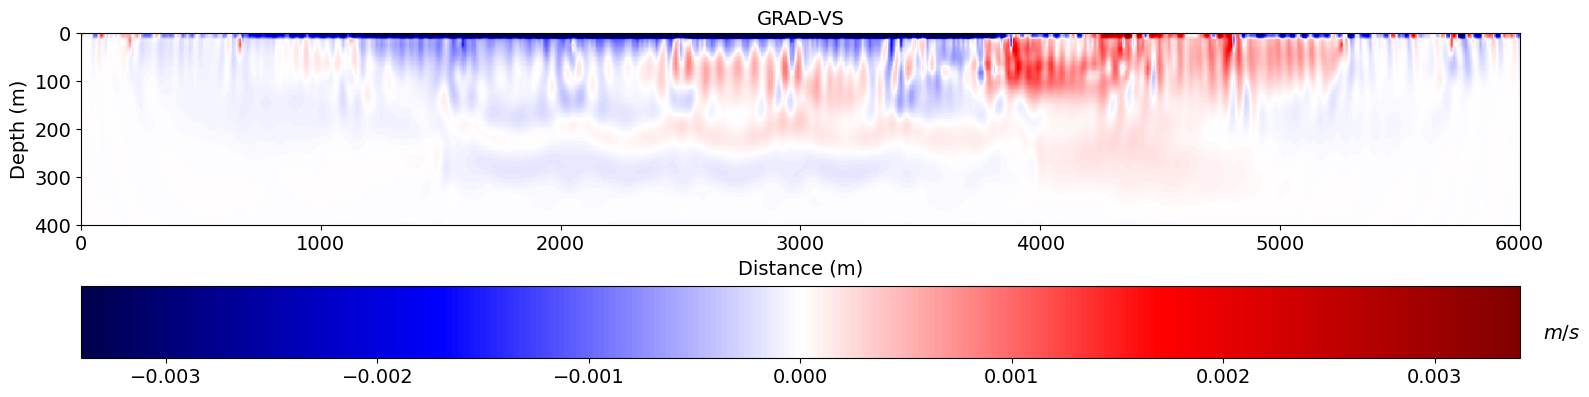

In [30]:
model_fwi_fd.plot(grad=True, cmap='seismic', clip=99.0, pars = 'vs', aspect=2)

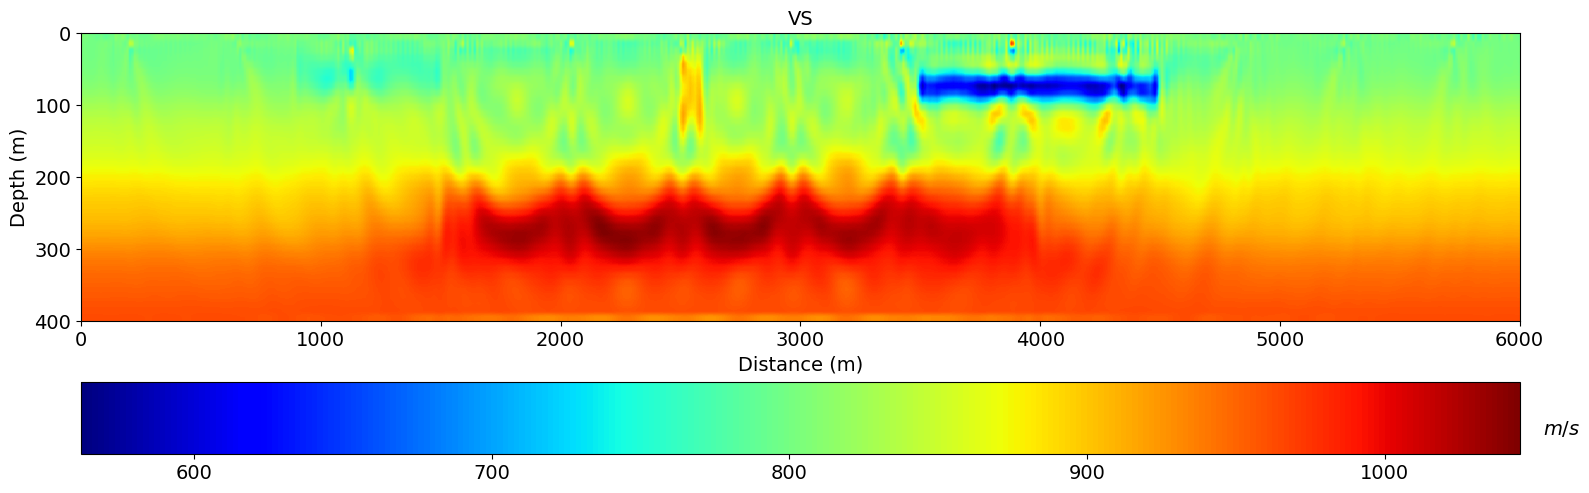

In [31]:
model_fwi_fd.plot(pars='vs', aspect=3)

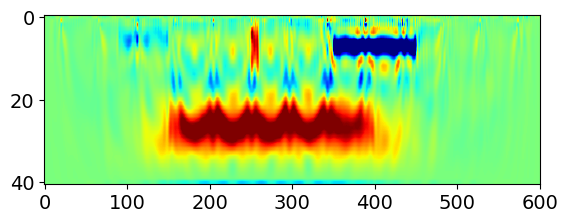

In [32]:
plt.imshow(model_fwi_fd.get_model('vs')-vs0, vmin=-100, vmax=100, cmap='jet', aspect=5)

### RBF

In [33]:
density = np.ones((nz, nx), dtype=np.float32)

for i in range(nx):
   density[:, i] = np.linspace(1, 0.5, nz)

density = smooth2d(density, 5, 5)

# Define mesh size bounds
mesh_min = 15
# mesh_max = 80
# mesh_max = 100
mesh_max = 90

centers_2d, mesh_sizes = gmsh_center2d(density.T, mesh_min, mesh_max, dx)

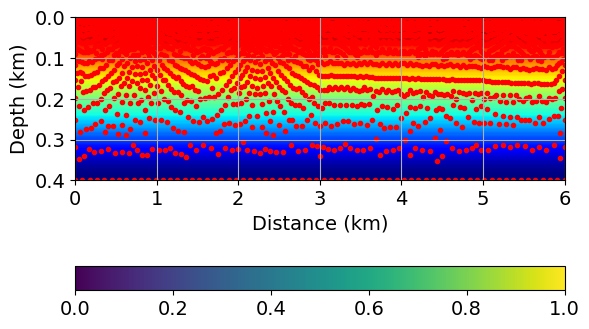

In [34]:
plot_2d(x, z, density, centers_2d, aspect=5)

In [35]:
sigma = set_sigma(centers_2d, 1.0)
theta_vp = np.zeros(len(centers_2d))
theta_vs = np.zeros(len(centers_2d))
theta_rho = np.zeros(len(centers_2d))

model_fwi_rbf = ElasticModelRBF(ox, oz, dx, dz, nx, nz, 
                                  centers = centers_2d, 
                                  theta_vp = theta_vp, 
                                  theta_vs = theta_vs, 
                                  theta_rho = theta_rho, 
                                  sigma = sigma,
                                  update_theta_vp = False,
                                  update_theta_vs = True,
                                  update_sigma = False,
                                  vp = vp0, 
                                  vs = vs0, 
                                  rho = rho0, 
                                  vp_bound = [500, 5000],
                                  vs_bound = [300, 3000],
                                  free_surface=True, 
                                  nabc=20,
                                  mask = grad_mask)

Precomputing the RBF ...


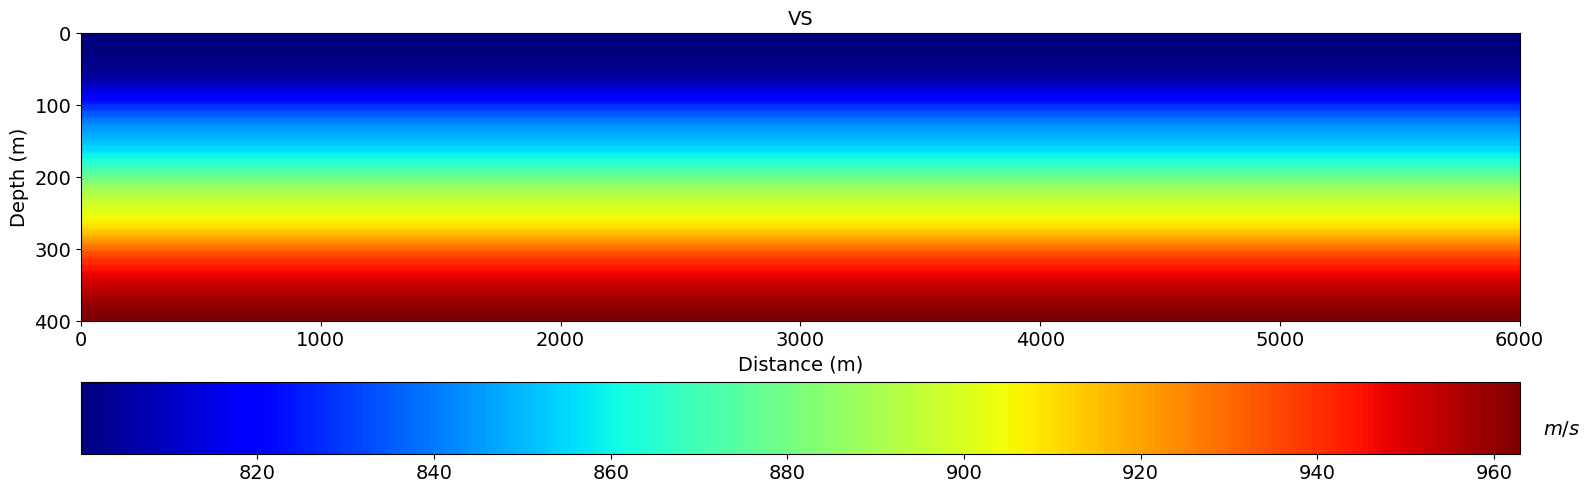

In [36]:
model_fwi_rbf.plot(aspect=3, pars='vs')

In [37]:
# Setup optimizer
optimizer = torch.optim.LBFGS(model_fwi_rbf.parameters(), 
                  lr = 1.0, 
                  max_iter = 50, 
                  tolerance_change = 1e-4,
                  history_size = 5,
                  line_search_fn = 'strong_wolfe')

# Setup misfit function
misfit = torch.nn.MSELoss()

# Setup components
weight = {'vz': 1.0}

In [38]:
fwi_rbf = ElasticFWI(F, model_fwi_rbf, optimizer, misfit, dobs, weight)

In [39]:
fwi_rbf(nshot_per_gpu_per_batch = 8, max_iter=2, grad_scale = 20.0, grad_interval=4, log_file = 'fwi-surface-wave-rbf.log', cache_result=True)

**********************************************************
            PyTorch l-BFGS Optimizer                
***********************************************************
     Convergence criterion  :   1.00e-04
     Max iteration          :         50
***********************************************************

   Niter           fk                ngrad          max grad
     1       1.730216e+03                1         1.00e+00
     1       1.728768e+03                1         9.99e-01
     1       1.712891e+03                1         9.93e-01
     1       1.559736e+03                1         9.18e-01
     1       9.553687e+02                1         3.42e-01
     2       6.950384e+02                6         3.03e-01
     3       5.244406e+02                7         4.90e-02
     4       3.346415e+02                8         5.31e-02
     5       2.739569e+02                9         2.29e-01
     6       2.292874e+02               10         7.58e-02
     7       2.109425e+0

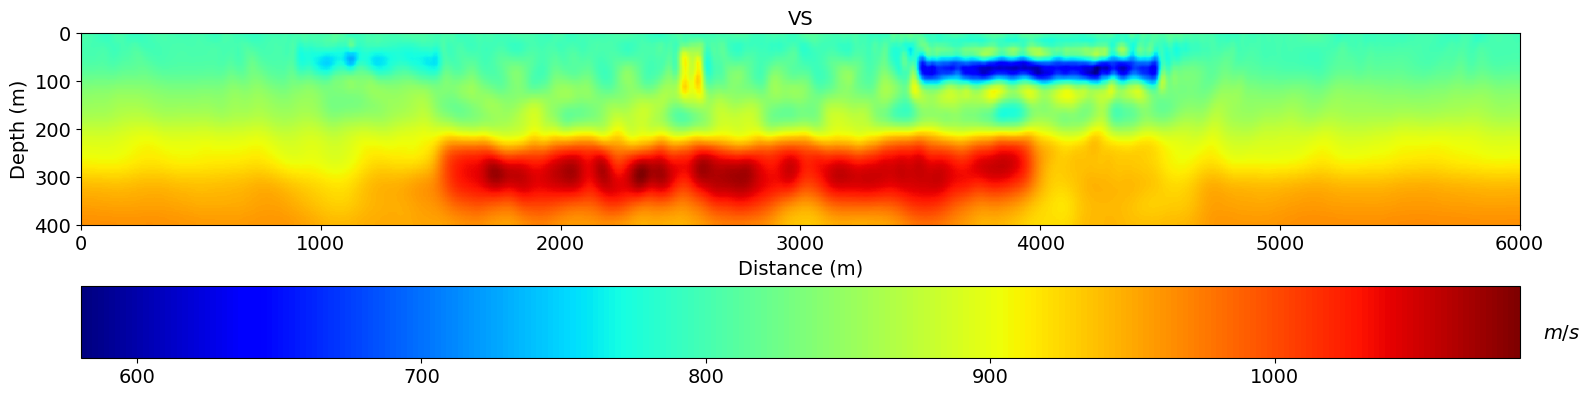

In [40]:
model_fwi_rbf.plot(pars='vs', aspect=2)

In [41]:
vs_fd  = model_fwi_fd.get_model('vs')
vs_rbf = model_fwi_rbf.get_model('vs')

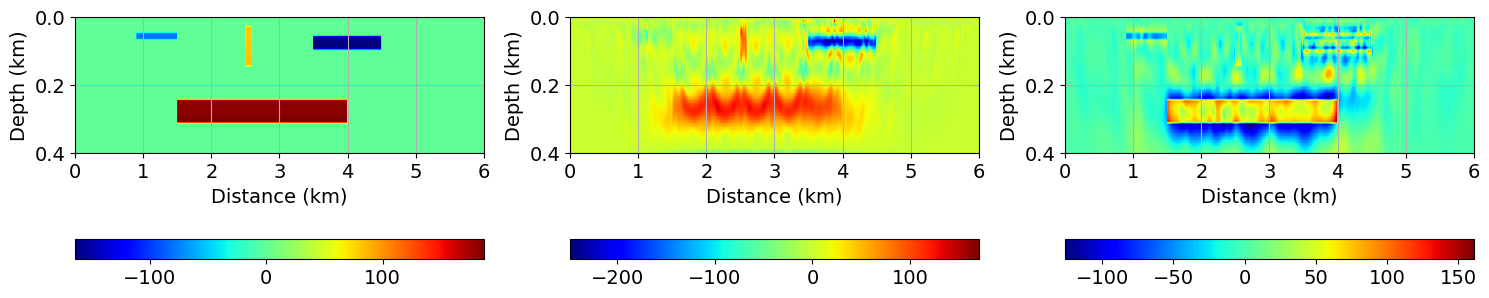

In [42]:
plot_2d(x, z, [vs-vs0, vs_fd-vs0, vs-vs_rbf])

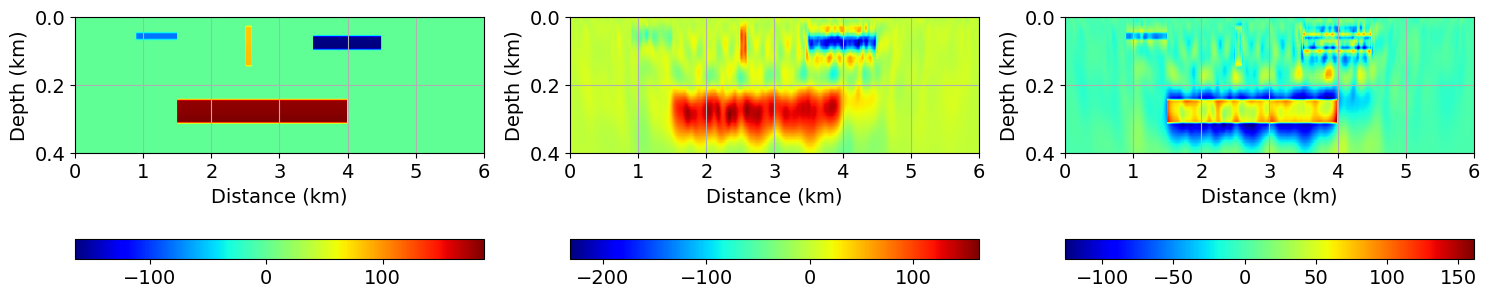

In [43]:
plot_2d(x, z, [vs-vs0, vs_rbf-vs0, vs-vs_rbf])

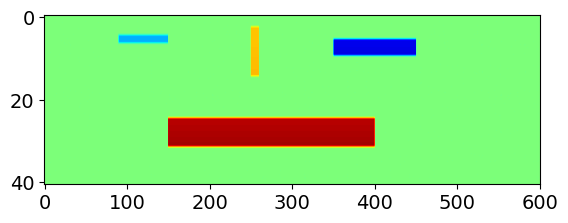

In [44]:
plt.imshow(vs-vs0, vmin=-200, vmax=200, cmap='jet', aspect=5)

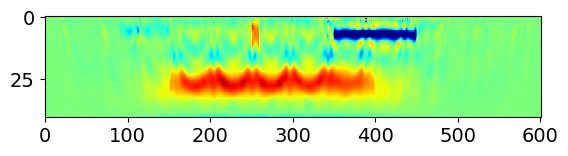

In [45]:
plt.imshow(vs_fd-vs0, vmin=-150, vmax=150, cmap='jet', aspect=3)

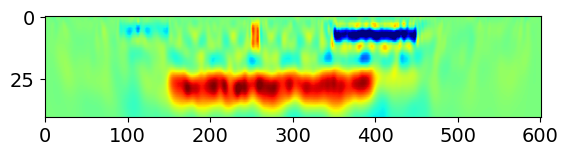

In [46]:
plt.imshow(vs_rbf-vs0, vmin=-150, vmax=150, cmap='jet', aspect=3)

In [47]:
loss_fd  = load_misfit('fwi-surface-wave-fd.log')
loss_rbf = load_misfit('fwi-surface-wave-rbf.log')

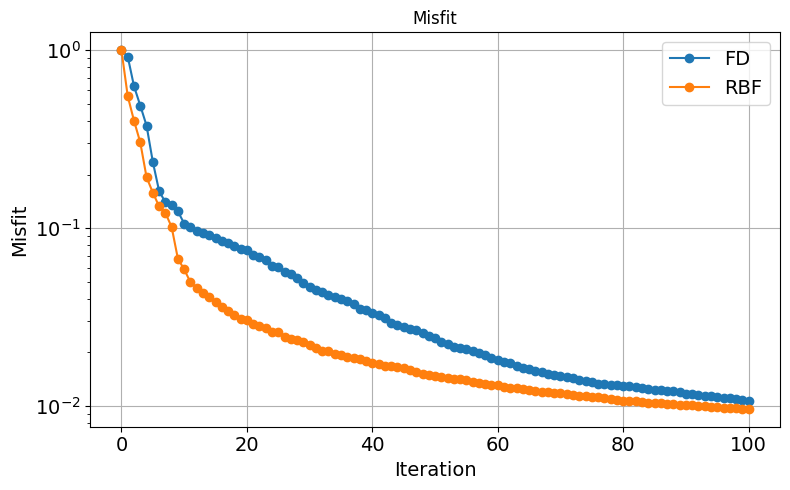

In [48]:
plot_misfit([loss_fd, loss_rbf], label=['FD', 'RBF'])

In [49]:
(nx*nz)/centers_2d.shape[0]

8.216405468489496

In [50]:
# vp_chached = fwi.vs_chached
# vp_chached = np.array(vp_chached) - vp_bl_fwi

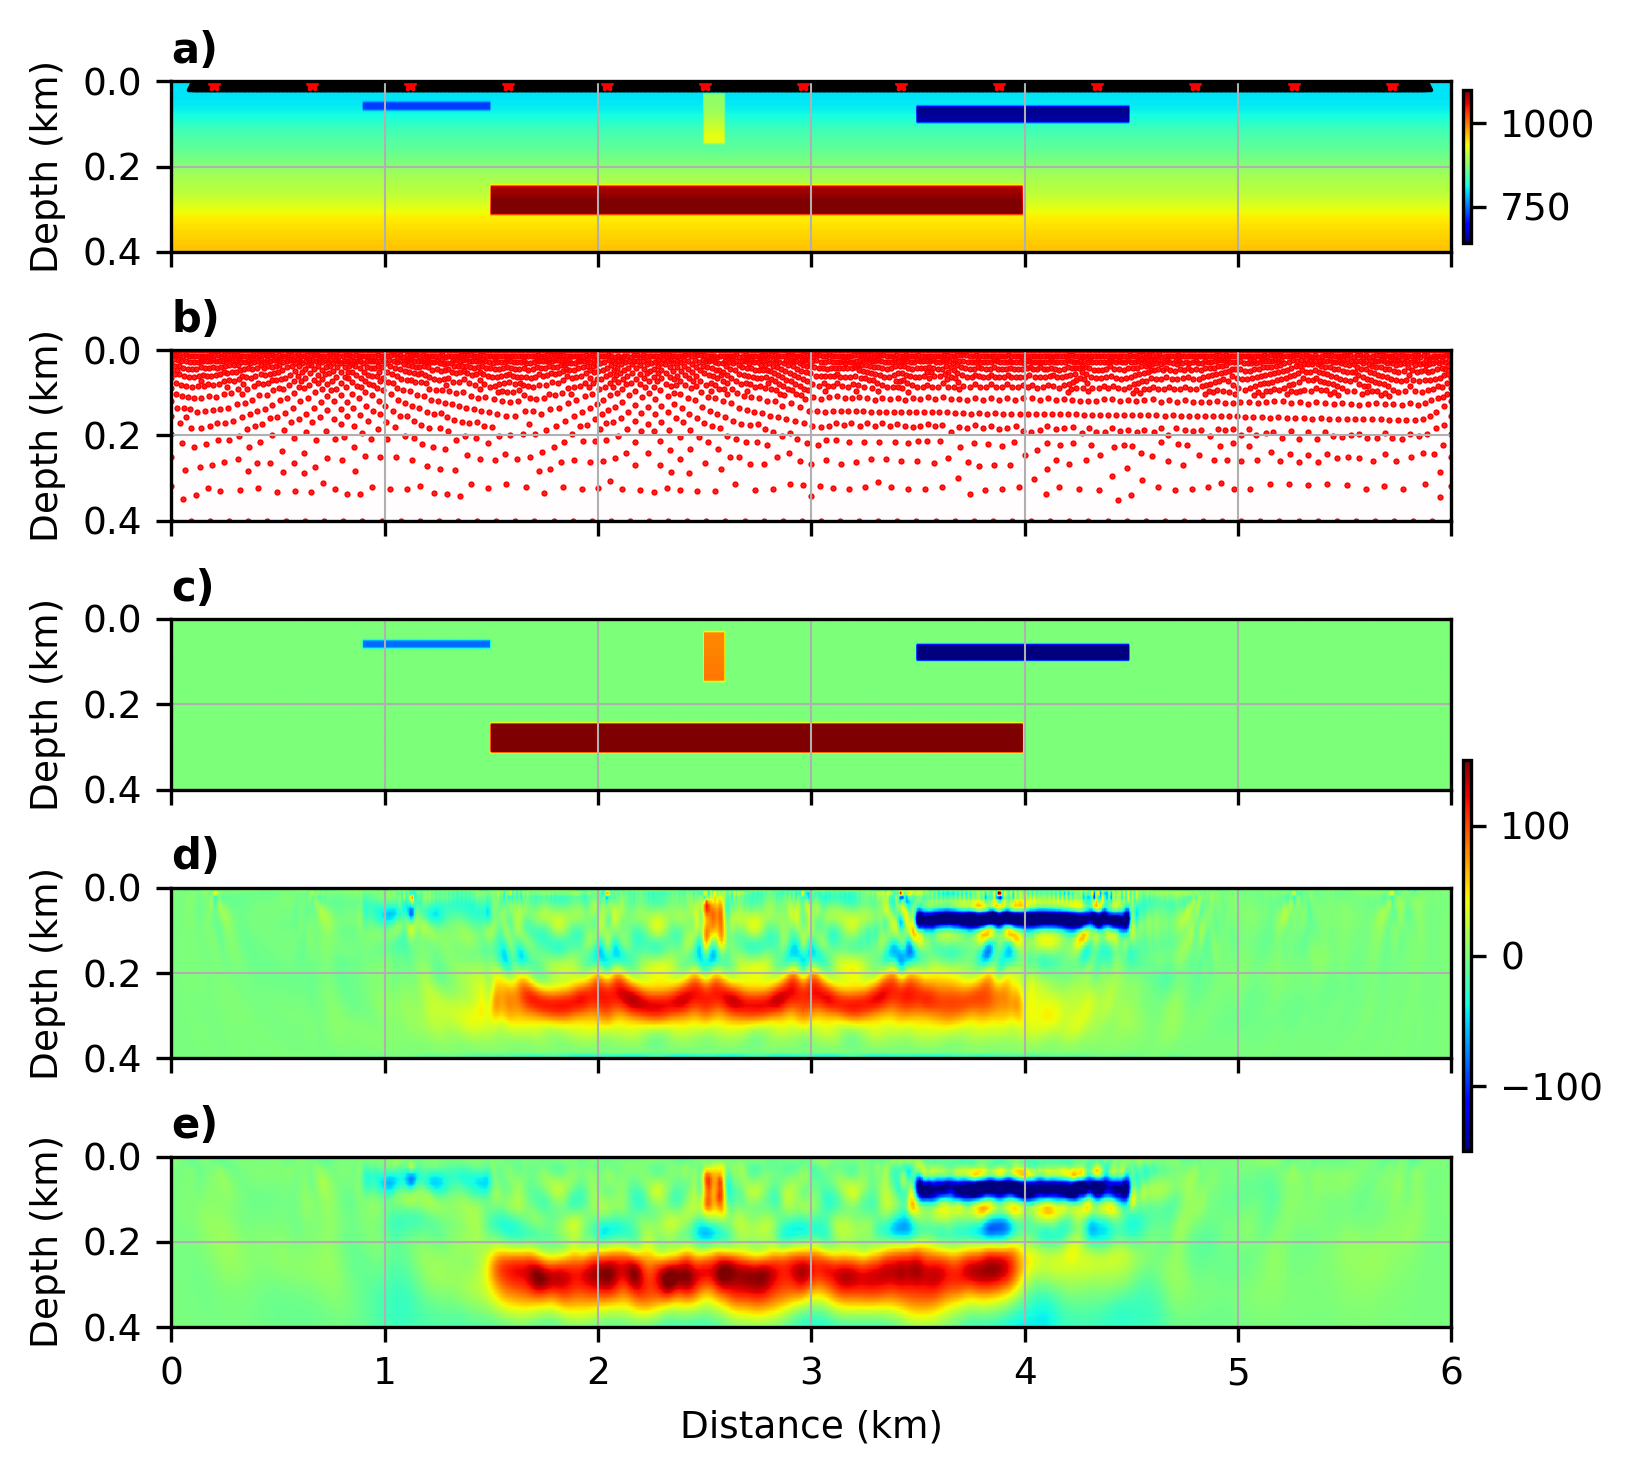

In [51]:
fontsize = 9
plt.rcParams.update({
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,
        "figure.titlesize": fontsize,
})


fig, axs = plt.subplots(5, 1, figsize=(6, 4.8), dpi=300, constrained_layout=True)

vs_fwi_fd = model_fwi_fd.get_model('vs')
vs_fwi_rbf = model_fwi_rbf.get_model('vs')

aspect=2
extent = [x[0]/1000, x[-1]/1000, z[-1]/1000, z[0]/1000]
cmap_range = [(640, 1100), (-100, 100), (-150, 150), (-150, 150), (-150, 150)]
labels = ['a)', 'b)', 'c)',  'd)', 'e)', 'f)']
cmaps = ['jet', 'seismic', 'jet', 'jet', 'jet']


ims = []
for k, model in enumerate([vs,  vs - vs,  vs-vs0,  vs_fwi_fd-vs0,  vs_fwi_rbf - vs0]):
    if k<5:
        im = axs[k].imshow(model, extent=extent, cmap=cmaps[k], vmin=cmap_range[k][0], vmax=cmap_range[k][1], aspect=aspect)
        axs[k].grid(alpha=1, linewidth=0.5)
        # axs[k].colorbar()
    if k==1:
        im = axs[k].scatter(centers_2d[:,0]/1000, centers_2d[:,1]/1000,  marker='.', color = 'r', s=1)
        axs[k].set_xlim([x[0]/1000, x[-1]/1000])
        axs[k].set_ylim([z[0]/1000, z[-1]/1000])
        axs[k].invert_yaxis()
    if k == 5:
        axs[k].semilogy(loss_fd/loss_fd[0],  linestyle='-', label='FD')
        axs[k].semilogy(loss_rbf/loss_rbf[0],  linestyle='-', label='RBF')
        # plt.legend()
    ims.append(im)

    if k == 4:
        axs[k].set_xlabel("Distance (km)")
    else:
        axs[k].set_xticklabels([])
    axs[k].set_ylabel("Depth (km)")

    # plot the survey
    if k == 0:
        src = survey.source.get_loc(type='vz')
        rec_vx = survey.receiver.get_loc(type='vx')
        rec_vz = survey.receiver.get_loc(type='vz')
        axs[k].scatter(rec_vx[:, 0]/1000, rec_vx[:, 1]/1000, label='GEO-X', marker='^', s=5, c='k', )
        axs[k].scatter(rec_vz[:, 0]/1000, rec_vz[:, 1]/1000, label='GEO-Z', marker='^', s=5, c='k', )
        axs[k].scatter(src[:, 0]/1000, src[:, 1]/1000,      label='Source', marker='*', s=5, c='r')
     
    axs[k].text(-0.0, 1.3, labels[k], transform=axs[k].transAxes, fontsize=10, va='top', fontweight='bold')

    # if k == 4:
    #     cbar = fig.colorbar(ims[0], ax=axs[i, j], location='bottom', pad=0.02, shrink=0.7, aspect=25)
    #     cbar.ax.tick_params(labelsize=9)

cbar = fig.colorbar(ims[0], ax=axs[0], location='right', pad=0.0, shrink=0.9, aspect=20)
cbar.ax.tick_params(labelsize=9)

cbar = fig.colorbar(ims[2], ax=axs[1:], location='right', pad=0.0, shrink=0.4, aspect=50, anchor=(0.0, 0.3))
cbar.ax.tick_params(labelsize=9)

plt.savefig('FWI-Surface-wave.png', dpi=300, bbox_inches='tight')
plt.show()

## Check model reduction

In [55]:
misfit_model_fd = []
for mm in fwi_fd.vs_chached:
    misfit_model_fd.append(np.sum(abs(mm-vs)))

misfit_model_rbf = []
for mm in fwi_rbf.vs_chached:
    misfit_model_rbf.append(np.sum(abs(mm-vs)))

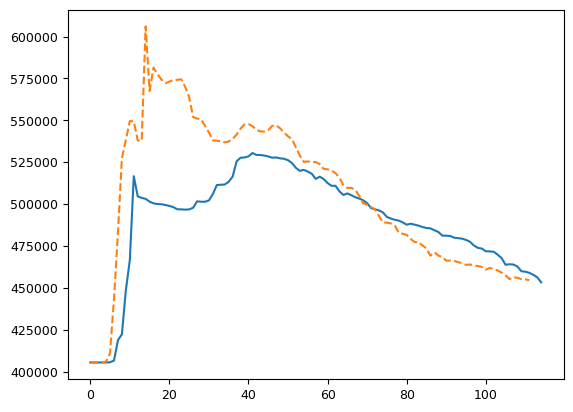

In [60]:
plt.plot(misfit_model_fd)
plt.plot(misfit_model_rbf, '--')